# OFDR Calibration for Spiral Waveguides (Silicon)
This notebook performs a basic analysis of OFDR (Optical Frequency Domain Reflectometry) datasets collected from spiral silicon waveguides. It demonstrates how to:
- Load OFDR plain-text datasets and show basic file metadata
- Detect reflection peaks along the measured length
- Filter the dataset to a specific length range and visualize it
- Perform a linear fit over a short section to estimate propagation loss (dB/cm)

Prerequisites:
- The notebook expects the helper module `ofdr_utils.py` to be available in the same directory.
- The following Python packages should be available in the chosen kernel: `pandas`, `numpy`, `matplotlib`, `scipy`.

Notes:
- This notebook focuses on OFDR analysis; kernel or environment setup instructions are intentionally omitted. If you need help creating or selecting a kernel, let me know and I can add a short setup cell separately.

## 1) Load datasets and view metadata
We load two OFDR measurements (nominal 2 cm and 4 cm spirals). The helper functions in `ofdr_utils.py` return pandas DataFrames with length (cm) and magnitude (dB) columns.
The goals of this section:
- Demonstrate how to read the raw OFDR text files into DataFrames
- Print basic dataset counts and file metadata for quick verification
- Confirm the data columns and units before further processing

In [1]:
from utils.ofdr_utils import *

# Load both OFDR datasets
DATASET_2CM = "user_data/yiting_2cm_0p48um_Upper.txt"
DATASET_4CM = "user_data/yiting_4cm_0p48um_Upper.txt"

df_2cm = read_ofdr_txt(DATASET_2CM)
df_4cm = read_ofdr_txt(DATASET_4CM)

print(f"Dataset 2cm: {len(df_2cm)} data points")
print(f"Dataset 4cm: {len(df_4cm)} data points")

df_2cm_info = get_file_info(DATASET_2CM)
df_4cm_info = get_file_info(DATASET_4CM)

print("\n2cm file info:")
for key, value in df_2cm_info.items():
    print(f"  {key}: {value}")

print("\n4cm file info:")
for key, value in df_4cm_info.items():
    print(f"  {key}: {value}")





Dataset 2cm: 524288 data points
Dataset 4cm: 524288 data points

2cm file info:
  filename: yiting_2cm_0p48um_Upper.txt
  size_bytes: 18370907
  data_points: 524288
  length_range: (np.float64(-0.999995128), np.float64(24.7425644))
  amplitude_range: (np.float64(-106.193875), np.float64(-38.0367941))

4cm file info:
  filename: yiting_4cm_0p48um_Upper.txt
  size_bytes: 18370907
  data_points: 524288
  length_range: (np.float64(-0.999995128), np.float64(24.7425644))
  amplitude_range: (np.float64(-105.791436), np.float64(-39.9550064))


### 2) Detect reflection peaks
We use `find_reflection_peaks(df, threshold, distance)` to find local maxima in the magnitude (dB) along length. Useful parameters:
- `threshold` (dB): ignore peaks below this level
- `distance` (float): minimum separation between peaks in number of samples (or None to let the algorithm decide)

After running the detection, `plot_ofdr_data(df, peaks_df=peaks)` overlays the detected peak positions on the magnitude plot. Inspect the printed `peaks` DataFrame to see peak length and amplitude.

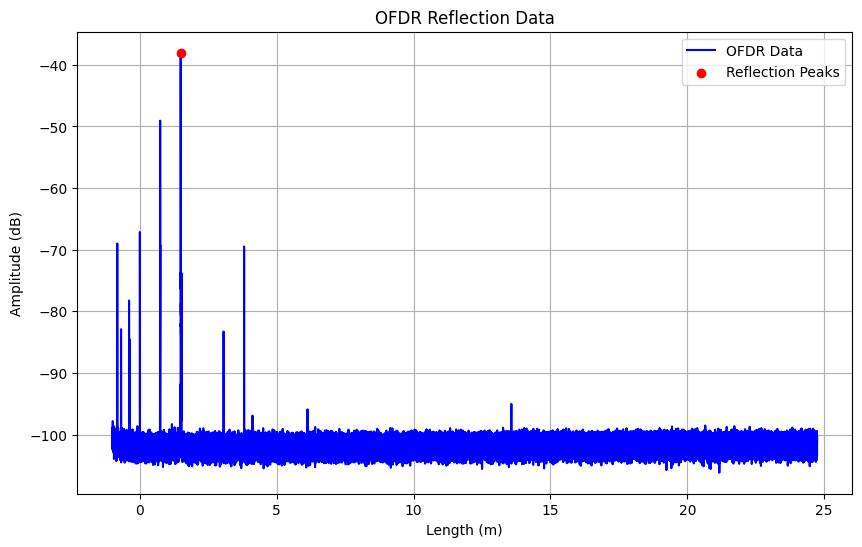


🎯 Peak Detection Results:
   Length_m  Amplitude_dB  peak_heights
0    1.4911    -38.036794    -38.036794


In [2]:
peaks = find_reflection_peaks(
    df_2cm,
    threshold=-40,
    distance=None,
)

plot_ofdr_data(df_2cm, peaks_df=peaks)

print(f"\n🎯 Peak Detection Results:")
print(peaks)

### 3) Filter data by length
Sometimes we only want to analyze a short section of the trace (e.g., a specific waveguide segment). Use `filter_data_by_length(df, min_length, max_length)` to get a subset. Plotting the filtered data helps visually confirm the region used for the linear fit and peak detection.

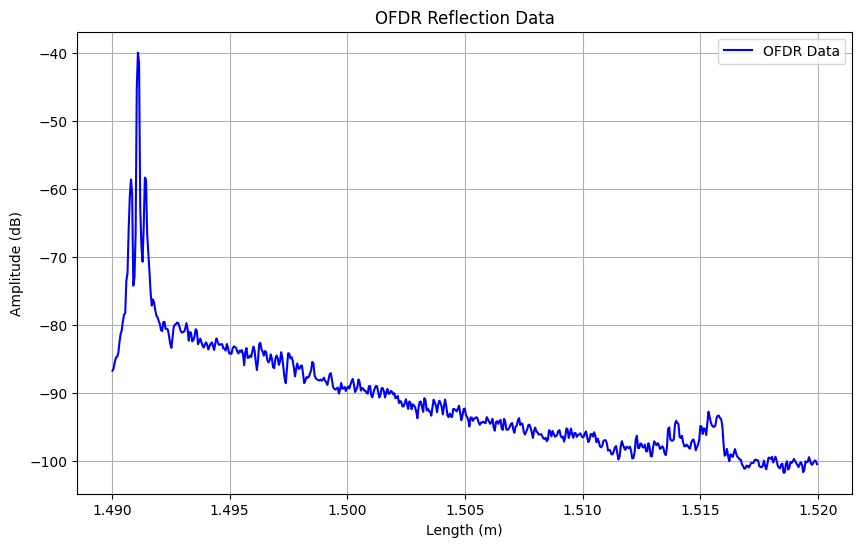

In [3]:
filtered_df = filter_data_by_length(df_4cm, 1.49, 1.52)
plot_ofdr_data(filtered_df, peaks_df=None)


### 4) Linear fit and propagation loss
We perform a linear fit on a short length interval using `linear_fit_within_range(df, min_length, max_length)` which returns `(slope, intercept)` for magnitude (dB) vs length (cm).
Propagation loss is computed from the slope; the notebook uses `propagation_loss_db_per_cm = 0.5 * slope/100` (this factor depends on measurement convention — check `ofdr_utils` documentation if unsure).
Units: slope has units dB per meter if lengths are in cm and scales may require conversion; confirm the units before using the result.

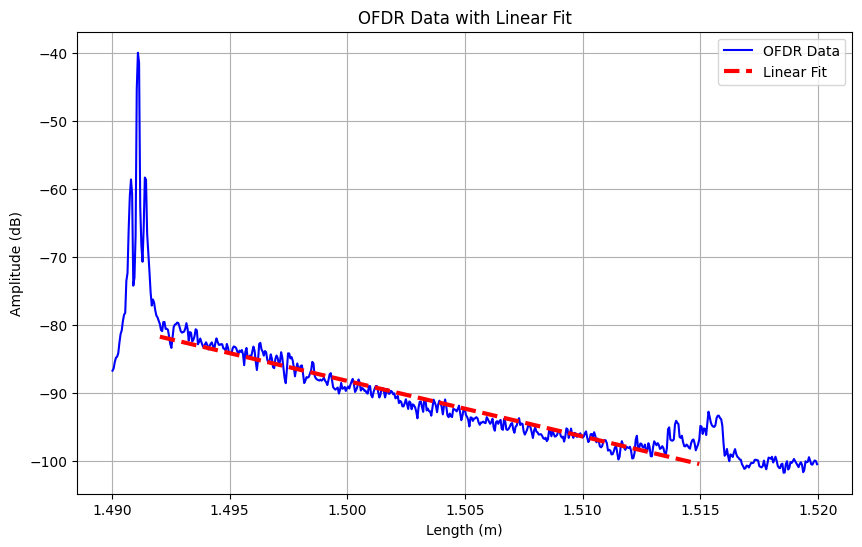

Propagation Loss: -4.09 dB/cm


In [ ]:
slope, intercept = linear_fit_within_range(filtered_df, 1.492, 1.515)
propagation_loss_db_per_cm = slope/200      # dB/cm (divide by 2 for one-way loss and by 100 for cm)
print(f"Propagation Loss: {propagation_loss_db_per_cm:.2f} dB/cm,")